# Project Description

You work at a startup that sells food products. You need to investigate user behavior for the company's app.

First study the sales funnel. Find out how users reach the purchase stage. How many users actually make it to this stage? How many get stuck at previous stages? Which stages in particular?

Then look at the results of an A/A/B test. (Read on for more information about A/A/B testing.) The designers would like to change the fonts for the entire app, but the managers are afraid the users might find the new design intimidating. They decide to make a decision based on the results of an A/A/B test.

The users are split into three groups: two control groups get the old fonts and one test group gets the new ones. Find out which set of fonts produces better results.

Creating two A groups has certain advantages. We can make it a principle that we will only be confident in the accuracy of our testing when the two control groups are similar. If there are significant differences between the A groups, this can help us uncover factors that may be distorting the results. Comparing control groups also tells us how much time and data we'll need when running further tests.

You'll be using the same dataset for general analytics and for A/A/B analysis. In real projects, experiments are constantly being conducted. Analysts study the quality of an app using general data, without paying attention to whether users are participating in experiments.

### Step - Open the data file and read the general information

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
from scipy import stats as st
import numpy as np
import math as mth


In [2]:
try:
    data = pd.read_csv('/datasets/logs_exp_us.csv', sep = '\t')
except:
    data = pd.read_csv('logs_exp_us.csv', sep='\t')

In [3]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**The data seems complete at this stage, there are no missing values. The EventTimestamp column shows the clear need to convert this into date format.**

### Step - Prepare the data for analysis
- Rename the columns in a way that's convenient for you
- Check for missing values and data types. Correct the data if needed
- Add a date and time column and a separate column for dates

In [5]:
# Renaming columns 

data = data.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'event_datetime', 'ExpId': 'exp_id'})


In [6]:
data.duplicated().sum()

413

In [7]:
(data.duplicated().sum()/len(data))*100

0.16917493425526162

**Only .16% of data is duplicated, seems like the right step is to drop these rows.**

In [8]:
# Dropping duplicates

data.drop_duplicates(inplace=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_name      243713 non-null  object
 1   user_id         243713 non-null  int64 
 2   event_datetime  243713 non-null  int64 
 3   exp_id          243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


In [10]:
# Checking if there are users who went to more (or less) than 1 group

repeated_groups = data.groupby('user_id')['exp_id'].nunique().reset_index()
repeated_groups[repeated_groups['exp_id']!=1]

,user_id,exp_id


In [11]:
# Add a date and time column and a separate column for dates

data['event_datetime'] = pd.to_datetime(data['event_datetime'], unit='s')
data['event_date'] = data['event_datetime'].dt.date
data['event_time'] = data['event_datetime'].dt.time

In [12]:
data.head()

,event_name,user_id,event_datetime,exp_id,event_date,event_time
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42


In [13]:
# Checking for missing values

data.isna().sum()

event_name        0
user_id           0
event_datetime    0
exp_id            0
event_date        0
event_time        0
dtype: int64

- **No missing values were found in the data**
- **The EventTimestamp column was converted into date format.**
- **.16% of data was duplicated and we dropped these rows.**
- **There were no unique uid's that showed going into more than 1 group, which is good news**

### Step - Study and check the data
- How many events are in the logs?
- How many users are in the logs?
- What's the average number of events per user?
- What period of time does the data cover? Find the maximum and the minimum date. Plot a histogram by date and time. Can you be sure that you have equally complete data for the entire period? Older events could end up in some users' logs for technical reasons, and this could skew the overall picture. Find the moment at which the data starts to be complete and ignore the earlier section. What period does the data actually represent?
- Did you lose many events and users when excluding the older data?
- Make sure you have users from all three experimental groups.


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_name      243713 non-null  object        
 1   user_id         243713 non-null  int64         
 2   event_datetime  243713 non-null  datetime64[ns]
 3   exp_id          243713 non-null  int64         
 4   event_date      243713 non-null  object        
 5   event_time      243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 13.0+ MB


In [15]:
# How many events are in the logs?

data['event_name'].count()

243713

In [16]:
data.groupby('event_name')['event_name'].nunique()

event_name
CartScreenAppear           1
MainScreenAppear           1
OffersScreenAppear         1
PaymentScreenSuccessful    1
Tutorial                   1
Name: event_name, dtype: int64

**There are 5 unique events, and 243713 separate ones**

In [17]:
#How many users are in the logs?

data['user_id'].nunique()

7551

**There are 7551 unique users in the data**

In [18]:
# What's the average number of events per user?

data.groupby('user_id')['event_name'].count().mean()

32.27559263673685

In [19]:
unique_users = data.groupby('user_id').nunique()
unique_users = unique_users['exp_id']
unique_users = unique_users.to_frame().reset_index()


events_per_user = data.groupby('user_id')['event_name'].count()
events_per_user = events_per_user.to_frame().reset_index()

events_per_user = unique_users.merge(events_per_user, on='user_id')
events_per_user = events_per_user.drop('user_id', axis=1)
events_per_user.columns = ['user_id', 'number_of_events']
events_per_user.describe()

,user_id,number_of_events
count,7551.0,7551.000000
mean,1.0,32.275593
std,0.0,65.154219
min,1.0,1.000000
25%,1.0,9.000000
50%,1.0,20.000000
75%,1.0,37.000000
max,1.0,2307.000000


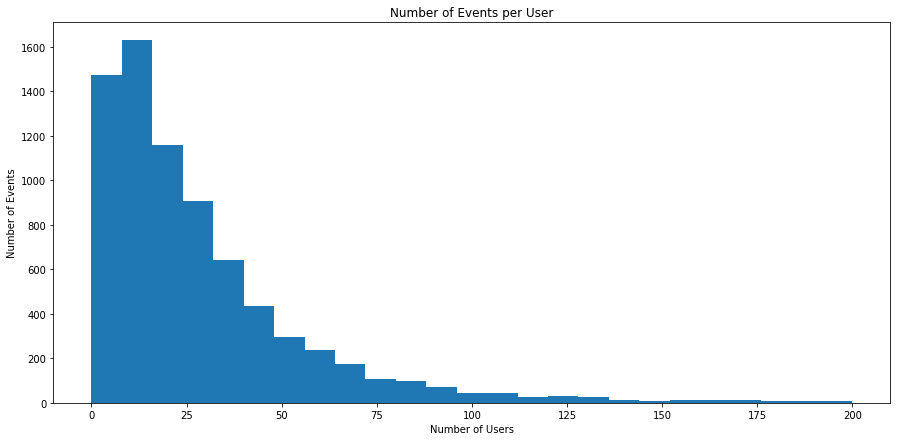

In [20]:
plt.figure(figsize=(15,7))
events_per_user['number_of_events'].hist(range=(0,200),bins=25, grid=False)
plt.title("Number of Events per User")
plt.xlabel("Number of Users")
plt.ylabel("Number of Events")
plt.show()

- **The maximum number of events per user is 2307, but this can clearly be considered an outlier.** 
- **The average number of events per user is around 30, while anything above around 100 can be considered an outlier**

In [21]:
# What period of time does the data cover? Find the maximum and the minimum date. 

data['event_date'].min()

datetime.date(2019, 7, 25)

In [22]:
data['event_date'].max()

datetime.date(2019, 8, 7)

In [23]:
events_per_date = data['event_date'].value_counts()
len(events_per_date)

14

**There are 14 days covered in the data**

In [24]:
# Plot a histogram by date and time. Can you be sure that you have equally complete data for the entire period? 

data.pivot_table(index='event_date', columns='event_name',values='user_id', aggfunc='nunique')

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
event_date,,,,,
2019-07-25,2.0,4.0,1.0,2.0,NaN
2019-07-26,6.0,15.0,3.0,3.0,1.0
2019-07-27,4.0,30.0,9.0,1.0,2.0
2019-07-28,19.0,42.0,12.0,12.0,NaN
2019-07-29,19.0,108.0,16.0,9.0,NaN
2019-07-30,45.0,214.0,49.0,32.0,NaN
2019-07-31,193.0,649.0,238.0,118.0,8.0
2019-08-01,1510.0,3545.0,2050.0,1372.0,155.0
2019-08-02,1525.0,3485.0,2070.0,1394.0,145.0


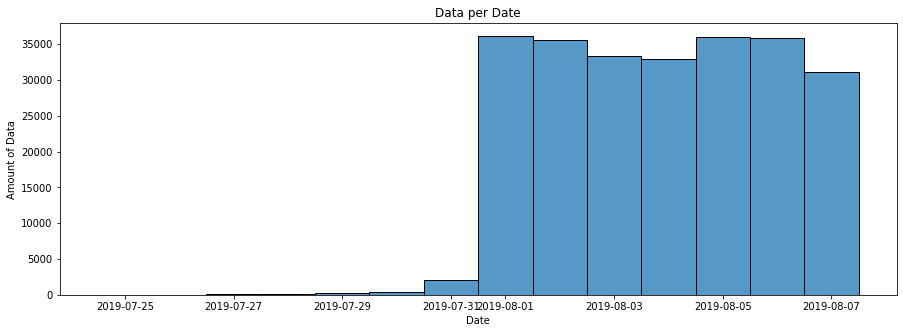

In [25]:
plt.figure(figsize=(15,5))
ax = sns.histplot(data=data['event_date'],bins=14).set(title='Data per Date')
plt.xlabel("Date")
plt.ylabel("Amount of Data")
plt.show()

**Seems that the data starts being complete from 2019-08-01, since on previous dates there are too few entries.**

In [26]:
# Older events could end up in some users' logs for technical reasons, and this could skew the overall picture. 
# Find the moment at which the data starts to be complete and ignore the earlier section. 
# What period does the data actually represent?

In [27]:
data['user_id'].nunique()

7551

In [28]:
# Checking the amount of unique users that belong to dates previous to 2019-08-01, to see if we can drop them entirely

doto = data
doto['event_date'] = pd.to_datetime(doto['event_date'])
doto = doto[doto['event_date'] < '2019-08-01']

doto['user_id'].nunique()

1451

**There are 1451 unique users that participated in the experiment on dates previous to 2019-08-01, which is about 20% of all unique users. To ensure reliability of the experiment, I will drop all users from problematic dates from the data.**

In [29]:
# Creating a list of user_id's from users who participated in incomplete dates, prior to 2019-08-01

problematic_ids = doto['user_id']
problematic_ids

0       4575588528974610257
1       7416695313311560658
2       3518123091307005509
3       3518123091307005509
4       6217807653094995999
               ...         
2823    2413191300976302222
2824    5505110279185484837
2825    5505110279185484837
2826    5505110279185484837
2827    2413191300976302222
Name: user_id, Length: 2826, dtype: int64

In [30]:
# Calculating number of rows with user_id's from users who participated in incomplete dates

len(data[data['user_id'].isin(problematic_ids)])

60057

In [31]:
# Dropping all data from users who participated in problematic dates previous to 2019-08-01

data = data[~data['user_id'].isin(problematic_ids)]

In [32]:
# Checking the new min date from clean data

data['event_date'].min()

Timestamp('2019-08-01 00:00:00')

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183656 entries, 2828 to 244125
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_name      183656 non-null  object        
 1   user_id         183656 non-null  int64         
 2   event_datetime  183656 non-null  datetime64[ns]
 3   exp_id          183656 non-null  int64         
 4   event_date      183656 non-null  datetime64[ns]
 5   event_time      183656 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 9.8+ MB


**After removing 60057 rows the user_id's from dates previous to 2019-08-01, we are left with 183656 rows**

In [34]:
time_period = data['event_date'].value_counts().rename_axis('event_date').reset_index(name='count').sort_values(by='event_date')
time_period


,event_date,count
3,2019-08-01,26370
1,2019-08-02,27251
5,2019-08-03,25277
4,2019-08-04,25519
2,2019-08-05,27089
0,2019-08-06,27742
6,2019-08-07,24408


**After dropping all rows from user_ids from dates previous to 2019-08-01, the new set of data represents entries from 2019-08-01 - 2019-08-07**

In [35]:
# Make sure you have users from all three experimental groups.

data.groupby('exp_id')['user_id'].nunique()

exp_id
246    2030
247    2036
248    2034
Name: user_id, dtype: int64

### Step - Study the event funnel

- See what events are in the logs and their frequency of occurrence. Sort them by frequency.
- Find the number of users who performed each of these actions. Sort the events by the number of users. Calculate the proportion of users who performed the action at least once.
- In what order do you think the actions took place. Are all of them part of a single sequence? You don't need to take them into account when calculating the funnel.
- Use the event funnel to find the share of users that proceed from each stage to the next. (For instance, for the sequence of events A → B → C, calculate the ratio of users at stage B to the number of users at stage A and the ratio of users at stage C to the number at stage B.)
- At what stage do you lose the most users?
- What share of users make the entire journey from their first event to payment?



In [36]:
# See what events are in the logs and their frequency of occurrence. Sort them by frequency.

event_frequency = data.groupby('event_name')['user_id'].count().reset_index().sort_values(by='user_id',ascending=False)
event_frequency 

,event_name,user_id
1,MainScreenAppear,88829
2,OffersScreenAppear,35950
0,CartScreenAppear,32265
3,PaymentScreenSuccessful,25621
4,Tutorial,991


In [37]:
# Find the number of users who performed each of these actions. Sort the events by the number of users. 

sales_funnel = data.groupby('event_name')['user_id'].nunique().reset_index().sort_values(by='user_id',ascending=False).reset_index(drop=True) 
sales_funnel.columns = ['event_name', 'users_count']
sales_funnel


,event_name,users_count
0,MainScreenAppear,6017
1,OffersScreenAppear,3739
2,CartScreenAppear,3014
3,PaymentScreenSuccessful,2852
4,Tutorial,829


In [38]:
# Calculate the proportion of users who performed the action at least once.

total_unique = data['user_id'].nunique()
total_unique

6100

In [39]:
sales_funnel['proportion_of_users'] = ((sales_funnel['users_count']/total_unique)*100).round(2)
sales_funnel

,event_name,users_count,proportion_of_users
0,MainScreenAppear,6017,98.64
1,OffersScreenAppear,3739,61.30
2,CartScreenAppear,3014,49.41
3,PaymentScreenSuccessful,2852,46.75
4,Tutorial,829,13.59


In [40]:
# In what order do you think the actions took place. 

sales_sequence = data[data['event_name']!='Tutorial'].sort_values(by=['user_id', 'event_date', 'event_time'])

sales_sequence = sales_sequence.groupby('event_name')['user_id'].nunique().reset_index().sort_values(by='user_id',ascending=False).reset_index(drop=True) 
sales_sequence.columns = ['event_name', 'users_count']
sales_sequence


,event_name,users_count
0,MainScreenAppear,6017
1,OffersScreenAppear,3739
2,CartScreenAppear,3014
3,PaymentScreenSuccessful,2852


**The most logical order of the sales sequence is:**

    - MainScreenAppear
    - OffersScreenAppear
    - CartScreenAppear
    - PaymentScreenSuccessful
    
**The Tutorial could be at any stage of the funnel, but since it's not necessarily part of the sales sequence, it was taken out of the sales funnel**
    
    
    

In [41]:
data_with_no_tutorial = data[data['event_name']!='Tutorial'].sort_values(by=['user_id', 'event_date', 'event_time'])
data_with_no_tutorial

,event_name,user_id,event_datetime,exp_id,event_date,event_time
197263,MainScreenAppear,6888746892508752,2019-08-06 14:06:34,246,2019-08-06,14:06:34
209196,MainScreenAppear,6909561520679493,2019-08-06 18:52:54,247,2019-08-06,18:52:54
209199,PaymentScreenSuccessful,6909561520679493,2019-08-06 18:52:58,247,2019-08-06,18:52:58
209200,CartScreenAppear,6909561520679493,2019-08-06 18:52:58,247,2019-08-06,18:52:58
209201,MainScreenAppear,6909561520679493,2019-08-06 18:52:58,247,2019-08-06,18:52:58
...,...,...,...,...,...,...
221366,MainScreenAppear,9222603179720523844,2019-08-07 09:13:37,248,2019-08-07,09:13:37
221404,MainScreenAppear,9222603179720523844,2019-08-07 09:14:53,248,2019-08-07,09:14:53
221406,MainScreenAppear,9222603179720523844,2019-08-07 09:15:01,248,2019-08-07,09:15:01
221412,MainScreenAppear,9222603179720523844,2019-08-07 09:15:13,248,2019-08-07,09:15:13


In [42]:
def sequence(user):
    sorted_user = data_with_no_tutorial[data_with_no_tutorial['user_id']==(user)].sort_values(by=['user_id','event_date', 'event_time'])
    return sorted_user['event_name'].drop_duplicates().to_list()


In [43]:
sequence(6909561520679493)

['MainScreenAppear',
 'PaymentScreenSuccessful',
 'CartScreenAppear',
 'OffersScreenAppear']

In [44]:
sequence_empty = []
for i in data_with_no_tutorial.user_id.unique():
    sequence_empty.append([i,sequence(i)])

In [45]:
path_data = pd.DataFrame(sequence_empty, columns=['user', 'path'])
path_data

,user,path
0,6888746892508752,[MainScreenAppear]
1,6909561520679493,"[MainScreenAppear, PaymentScreenSuccessful, Ca..."
2,6922444491712477,"[MainScreenAppear, PaymentScreenSuccessful, Ca..."
3,7435777799948366,[MainScreenAppear]
4,7702139951469979,"[MainScreenAppear, OffersScreenAppear, CartScr..."
...,...,...
6091,9216094175241772920,[MainScreenAppear]
6092,9217594193087726423,"[PaymentScreenSuccessful, CartScreenAppear, Of..."
6093,9219463515465815368,"[MainScreenAppear, OffersScreenAppear, CartScr..."
6094,9221926045299980007,[MainScreenAppear]


In [46]:
(path_data['path'].map(tuple)).value_counts().head()

(MainScreenAppear,)                                                                  2315
(MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful)     745
(MainScreenAppear, OffersScreenAppear)                                                733
(MainScreenAppear, OffersScreenAppear, PaymentScreenSuccessful, CartScreenAppear)     604
(MainScreenAppear, PaymentScreenSuccessful, CartScreenAppear, OffersScreenAppear)     545
Name: path, dtype: int64

**It seems that just was we though so, the following order of events is the most common one:**

- MainScreenAppear
- OffersScreenAppear
- CartScreenAppear
- PaymentScreenSuccessful**

In [47]:
sales_sequence['proportion_of_all_users'] = ((sales_sequence['users_count']/total_unique)*100).round(2)
sales_sequence

,event_name,users_count,proportion_of_all_users
0,MainScreenAppear,6017,98.64
1,OffersScreenAppear,3739,61.30
2,CartScreenAppear,3014,49.41
3,PaymentScreenSuccessful,2852,46.75


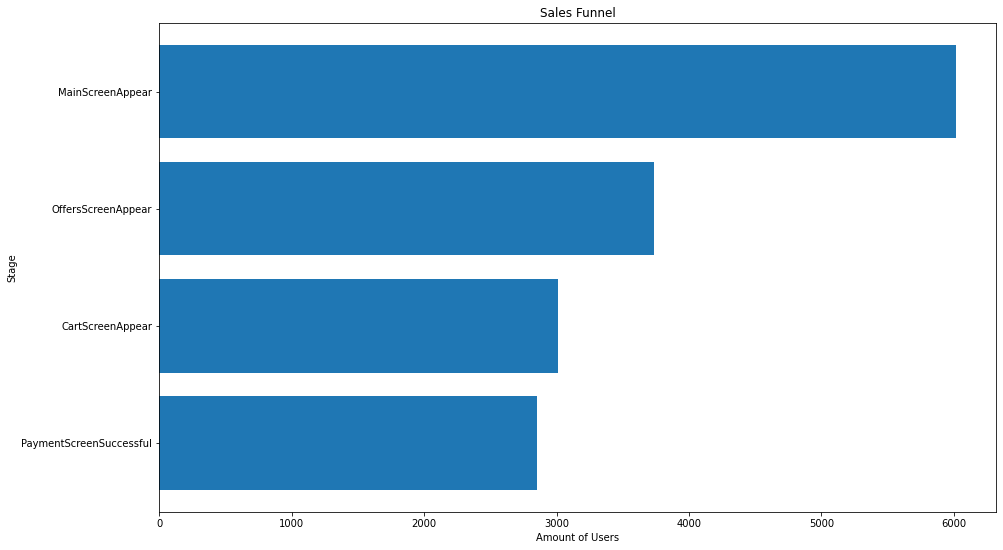

In [48]:
sales_sequence = sales_sequence.sort_values(by='users_count')

x = sales_sequence['users_count'][0:4]
y = sales_sequence['event_name'][0:4]
plt.figure(figsize=(15,9))
plt.title('Sales Funnel')
plt.barh(y, x)
plt.xlabel("Amount of Users")
plt.ylabel("Stage")
plt.show()

In [49]:
# Use the event funnel to find the share of users that proceed from each stage to the next. 

sales_sequence = sales_sequence.sort_values(by='users_count', ascending=False).reset_index(drop=True) 
sales_sequence['share_of_users'] = sales_sequence['users_count'].pct_change()
sales_sequence

,event_name,users_count,proportion_of_all_users,share_of_users
0,MainScreenAppear,6017,98.64,NaN
1,OffersScreenAppear,3739,61.30,-0.378594
2,CartScreenAppear,3014,49.41,-0.193902
3,PaymentScreenSuccessful,2852,46.75,-0.053749


**We are losing the most users at the first stage: from MainScreenAppear to OffersScreenAppear**

In [50]:
# What share of users make the entire journey from their first event to payment?

entire_journey_users = sales_sequence.loc[3, 'users_count']/sales_sequence.loc[0, 'users_count']*100
print('The share of users that make the entire journey from first event to payment is: {0:.2f}%'.format(entire_journey_users))

The share of users that make the entire journey from first event to payment is: 47.40%


### Step - Study the results of the experiment

- How many users are there in each group?
- We have two control groups in the A/A test, where we check our mechanisms and calculations. See if there is a statistically significant difference between samples 246 and 247.
- Select the most popular event. In each of the control groups, find the number of users who performed this action. Find their share. Check whether the difference between the groups is statistically significant. Repeat the procedure for all other events (it will save time if you create a special function for this test). Can you confirm that the groups were split properly?
- Do the same thing for the group with altered fonts. Compare the results with those of each of the control groups for each event in isolation. Compare the results with the combined results for the control groups. What conclusions can you draw from the experiment?
- What significance level have you set to test the statistical hypotheses mentioned above? Calculate how many statistical hypothesis tests you carried out. With a statistical significance level of 0.1, one in 10 results could be false. What should the significance level be? If you want to change it, run through the previous steps again and check your conclusions.

In [51]:
# How many users are there in each group?

total_group_users = data.groupby('exp_id').agg({'user_id':pd.Series.nunique}).reset_index()
total_group_users

,exp_id,user_id
0,246,2030
1,247,2036
2,248,2034


In [52]:
merged_events = data.pivot_table(index='event_name', columns='exp_id', values='user_id', aggfunc='nunique').reset_index()
merged_events

exp_id,event_name,246,247,248
0,CartScreenAppear,1030,1001,983
1,MainScreenAppear,2003,2009,2005
2,OffersScreenAppear,1272,1236,1231
3,PaymentScreenSuccessful,977,933,942
4,Tutorial,274,281,274


In [53]:
# We have two control groups in the A/A test, where we check our mechanisms and calculations. 
# See if there is a statistically significant difference between samples 246 and 247.

#H0: Groups 246 and 247 are statistically equal
#H1: Groups 246 and 247 are statistically different

def check_hypotheses(group1, group2, event, alpha):
    success1 = merged_events[merged_events['event_name']==event][group1].iloc[0]
    success2 = merged_events[merged_events['event_name']==event][group2].iloc[0]
    
    trials1 = data[data.exp_id == group1]['user_id'].nunique()
    trials2 = data[data.exp_id == group2]['user_id'].nunique()
    
    p1 = success1/trials1
    p2 = success2/trials2
    
    p_combined = (success1 + success2) / (trials1 + trials2)
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    
    distr = st.norm(0, 1)  
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-value: ', p_value)
    
    if (p_value < alpha):
        print("Rejecting the null hypothesis: group", group1, "and group", group2, "seem to be statistically different")
    else:
        print("Failed to reject the null hypothesis: group", group1, "and group", group2, "seem to be statistically equal") 

In [54]:
check_hypotheses(246, 247, 'PaymentScreenSuccessful', 0.05)

p-value:  0.141247268050253
Failed to reject the null hypothesis: group 246 and group 247 seem to be statistically equal


In [55]:
check_hypotheses(247, 248, 'PaymentScreenSuccessful', 0.05)

p-value:  0.7550423413727261
Failed to reject the null hypothesis: group 247 and group 248 seem to be statistically equal


In [56]:
check_hypotheses(246, 248, 'PaymentScreenSuccessful', 0.05)

p-value:  0.24641618157916545
Failed to reject the null hypothesis: group 246 and group 248 seem to be statistically equal


In [57]:
#Select the most popular event. In each of the control groups, find the number of users who performed this action. 
#Find their share. 

pd.options.mode.chained_assignment = None

most_popular_event = merged_events[merged_events['event_name']=='MainScreenAppear']

most_popular_event['246_share'] = (most_popular_event.loc[1,246]/total_group_users.loc[0,'user_id']).round(2)
most_popular_event['247_share'] = (most_popular_event.loc[1,247]/total_group_users.loc[1,'user_id']).round(2)
most_popular_event['248_share'] = (most_popular_event.loc[1,248]/total_group_users.loc[2,'user_id']).round(2)
most_popular_event

exp_id,event_name,246,247,248,246_share,247_share,248_share
1,MainScreenAppear,2003,2009,2005,0.99,0.99,0.99


In [58]:
# Check whether the difference between the groups is statistically significant.  

#H0: Groups 246 and 247 are statistically equal
#H1: Groups 246 and 247 are statistically different

check_hypotheses(246, 247, 'MainScreenAppear', 0.05)

p-value:  0.9912900454353855
Failed to reject the null hypothesis: group 246 and group 247 seem to be statistically equal


In [59]:
#H0: Groups 246 and 248 are statistically equal
#H1: Groups 246 and 248 are statistically different

check_hypotheses(246, 248, 'MainScreenAppear', 0.05)

p-value:  0.7935486985203337
Failed to reject the null hypothesis: group 246 and group 248 seem to be statistically equal


In [60]:
#H0: Groups 247 and 248 are statistically equal
#H1: Groups 247 and 248 are statistically different

check_hypotheses(247, 248, 'MainScreenAppear', 0.05)

p-value:  0.7849900563801253
Failed to reject the null hypothesis: group 247 and group 248 seem to be statistically equal


In [61]:
# Repeat the procedure for all other events 

check_hypotheses(246, 247, 'CartScreenAppear', 0.05)

p-value:  0.3155756208059124
Failed to reject the null hypothesis: group 246 and group 247 seem to be statistically equal


In [62]:
# Repeat the procedure for all other events 

check_hypotheses(246, 248, 'CartScreenAppear', 0.05)

p-value:  0.12435504369196737
Failed to reject the null hypothesis: group 246 and group 248 seem to be statistically equal


In [63]:
# Repeat the procedure for all other events 

check_hypotheses(247, 248, 'CartScreenAppear', 0.05)

p-value:  0.5934123911569555
Failed to reject the null hypothesis: group 247 and group 248 seem to be statistically equal


In [64]:
# Repeat the procedure for all other events 

check_hypotheses(246, 247, 'OffersScreenAppear', 0.05)

p-value:  0.2003094340863525
Failed to reject the null hypothesis: group 246 and group 247 seem to be statistically equal


In [65]:
# Repeat the procedure for all other events 

check_hypotheses(247, 248, 'OffersScreenAppear', 0.05)

p-value:  0.9032846142556277
Failed to reject the null hypothesis: group 247 and group 248 seem to be statistically equal


In [66]:
# Repeat the procedure for all other events 

check_hypotheses(246, 248, 'OffersScreenAppear', 0.05)

p-value:  0.16098977810039639
Failed to reject the null hypothesis: group 246 and group 248 seem to be statistically equal


In [67]:
# Creating function to compare combined control groups (246+247) with the test group (248)

def check_hypotheses_combined(group1, group2, group3, event, alpha):
    success1 = merged_events[merged_events['event_name']==event][group1].iloc[0]+merged_events[merged_events['event_name']==event][group2].iloc[0]
    success2 = merged_events[merged_events['event_name']==event][group3].iloc[0]
    
    trials1 = data[data.exp_id == group1]['user_id'].nunique()+data[data.exp_id == group2]['user_id'].nunique()
    trials2 = data[data.exp_id == group3]['user_id'].nunique()
    
    p1 = success1/trials1
    p2 = success2/trials2
    
    p_combined = (success1 + success2) / (trials1 + trials2)
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    
    distr = st.norm(0, 1)  
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-value: ', p_value)
    
    if (p_value < alpha):
        print("Rejecting the null hypothesis: group", group1, "+", group2, "and group", group3, "seem to be statistically different")
    else:
        print("Failed to reject the null hypothesis: group", group1, "+", group2, "and group", group3, "seem to be statistically equal") 

In [68]:
# Compare the results with the combined results for the control groups.

check_hypotheses_combined(246, 247, 248, 'CartScreenAppear',0.05)

p-value:  0.2321481954941762
Failed to reject the null hypothesis: group 246 + 247 and group 248 seem to be statistically equal


In [69]:
# Compare the results with the combined results for the control groups.

check_hypotheses_combined(246, 247, 248, 'MainScreenAppear',0.05)

p-value:  0.7562248156641758
Failed to reject the null hypothesis: group 246 + 247 and group 248 seem to be statistically equal


In [70]:
# Compare the results with the combined results for the control groups.

check_hypotheses_combined(246, 247, 248, 'OffersScreenAppear',0.05)

p-value:  0.38008156470322274
Failed to reject the null hypothesis: group 246 + 247 and group 248 seem to be statistically equal


In [71]:
# Compare the results with the combined results for the control groups.

check_hypotheses_combined(246, 247, 248, 'PaymentScreenSuccessful',0.05)

p-value:  0.6250481056471162
Failed to reject the null hypothesis: group 246 + 247 and group 248 seem to be statistically equal


- **Judging by the results of the experiment, there is no reason to consider the proportions of groups A/A and both A/B's to be different.**
- **The A/A test was performed correctly, however, we should take precaution when trusting the experiment, due to the initial problem found in the proportion of the data by the dates of the experiment.**
- **There seems to be no statistical difference in the proportions between the groups.**

In [72]:
# What significance level have you set to test the statistical hypotheses mentioned above? (0.05)
# Calculate how many statistical hypothesis tests you carried out. (16)
# With a statistical significance level of 0.1, one in 10 results could be false. 
# What should the significance level be?  


alpha = 0.05
num_of_tests = 16

fwer = 1 - (1 - alpha)** (num_of_tests)
bonferroni_alpha = alpha/num_of_tests

print('The family-wise error rate (FWER) is:', fwer)
print('The alpha level with Bonferroni correction is: ',bonferroni_alpha)

The family-wise error rate (FWER) is: 0.5598733313482347
The alpha level with Bonferroni correction is:  0.003125


In [73]:
# Run through the previous steps again and check conclusions.

check_hypotheses(246, 247, 'MainScreenAppear', bonferroni_alpha)

p-value:  0.9912900454353855
Failed to reject the null hypothesis: group 246 and group 247 seem to be statistically equal


In [74]:
check_hypotheses(247, 248, 'MainScreenAppear', bonferroni_alpha)

p-value:  0.7849900563801253
Failed to reject the null hypothesis: group 247 and group 248 seem to be statistically equal


In [75]:
check_hypotheses(246, 248, 'MainScreenAppear', bonferroni_alpha)

p-value:  0.7935486985203337
Failed to reject the null hypothesis: group 246 and group 248 seem to be statistically equal


In [76]:
check_hypotheses(246, 247, 'OffersScreenAppear', bonferroni_alpha)

p-value:  0.2003094340863525
Failed to reject the null hypothesis: group 246 and group 247 seem to be statistically equal


In [77]:
check_hypotheses(247, 248, 'OffersScreenAppear', bonferroni_alpha)

p-value:  0.9032846142556277
Failed to reject the null hypothesis: group 247 and group 248 seem to be statistically equal


In [78]:
check_hypotheses(246, 248, 'OffersScreenAppear', bonferroni_alpha)

p-value:  0.16098977810039639
Failed to reject the null hypothesis: group 246 and group 248 seem to be statistically equal


In [79]:
check_hypotheses(246, 247, 'CartScreenAppear', bonferroni_alpha)

p-value:  0.3155756208059124
Failed to reject the null hypothesis: group 246 and group 247 seem to be statistically equal


In [80]:
check_hypotheses(247, 248, 'CartScreenAppear', bonferroni_alpha)

p-value:  0.5934123911569555
Failed to reject the null hypothesis: group 247 and group 248 seem to be statistically equal


In [81]:
check_hypotheses(246, 248, 'CartScreenAppear', bonferroni_alpha)

p-value:  0.12435504369196737
Failed to reject the null hypothesis: group 246 and group 248 seem to be statistically equal


In [82]:
check_hypotheses(246, 247, 'PaymentScreenSuccessful', bonferroni_alpha)

p-value:  0.141247268050253
Failed to reject the null hypothesis: group 246 and group 247 seem to be statistically equal


In [83]:
check_hypotheses(247, 248, 'PaymentScreenSuccessful', bonferroni_alpha)

p-value:  0.7550423413727261
Failed to reject the null hypothesis: group 247 and group 248 seem to be statistically equal


In [84]:
check_hypotheses(246, 248, 'PaymentScreenSuccessful', bonferroni_alpha)

p-value:  0.24641618157916545
Failed to reject the null hypothesis: group 246 and group 248 seem to be statistically equal


In [85]:
check_hypotheses_combined(246, 247, 248, 'MainScreenAppear', bonferroni_alpha)

p-value:  0.7562248156641758
Failed to reject the null hypothesis: group 246 + 247 and group 248 seem to be statistically equal


In [86]:
check_hypotheses_combined(246, 247, 248, 'OffersScreenAppear', bonferroni_alpha)

p-value:  0.38008156470322274
Failed to reject the null hypothesis: group 246 + 247 and group 248 seem to be statistically equal


In [87]:
check_hypotheses_combined(246, 247, 248, 'CartScreenAppear', bonferroni_alpha)

p-value:  0.2321481954941762
Failed to reject the null hypothesis: group 246 + 247 and group 248 seem to be statistically equal


In [88]:
check_hypotheses_combined(246, 247, 248, 'PaymentScreenSuccessful', bonferroni_alpha)

p-value:  0.6250481056471162
Failed to reject the null hypothesis: group 246 + 247 and group 248 seem to be statistically equal


# Conclusions

**Exploratory Analysis**
- The data was complete, there were no missing values found. However, the distribution of data by date did not show normality on dates previous to 2019-08-01, therefore, this data was dropped
- .16% of data was duplicated and we dropped these rows
- The average number of events per user is around 30, while anything above around 100 can be considered an outlier


**Sales Funnel**

The following order of events is the most common one:

- MainScreenAppear
- OffersScreenAppear
- CartScreenAppear
- PaymentScreenSuccessful

**Experiment Conclusions**
- Judging by the results of the experiment, it seems the groups were split properly. There seems to be no statistical difference in the proportions between the groups.

- There is no reason to consider the proportions of groups A/A and both A/B's to be different.

- The A/A test was performed correctly, however, we should take precaution when trusting the experiment, due to the initial problem found in the the way the data was distributed by the dates of the experiment.

- Since the users that completed step 3 (PaymentScreenSuccessful) in group 248 were not significanty higher than the users that completed step 3 in the control groups (246 and 247), **we can conclude that the change in fonts did not have a significantly positive effect in conversion.**